In [1]:
%pip install keras-tuner --upgrade

In [27]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import subprocess

In [3]:
subprocess.run(['java', '-jar', 'createDataset.jar', '-ss', 'RandomConfiguration', '-m', '100', '-fm', './bcs_v1.xml', '-c', './products.csv'], capture_output=True)

CompletedProcess(args=['java', '-jar', 'createDataset.jar', '-ss', 'RandomConfiguration', '-m', '100', '-fm', './bcs_v1.xml', '-c', './products.csv'], returncode=0, stdout=b'', stderr=b'')

In [4]:
# get dataset
dataset = pd.read_csv("Data/Apache_AllNumeric.csv")
dataset = dataset.sample(frac=1)
dataset_features = dataset.copy()
dataset_labels = dataset_features.pop('PERF')

In [5]:
dataset

,HostnameLookups,KeepAlive,EnableSendfile,FollowSymLinks,AccessLog,ExtendedStatus,InMemory,Handle,PERF
74,1,0,0,1,1,0,0,1,930
147,1,0,1,1,1,0,0,0,960
43,0,0,1,0,0,1,0,1,1140
39,0,0,0,1,1,0,0,1,1200
11,1,0,1,0,0,1,1,0,1020
...,...,...,...,...,...,...,...,...,...
143,1,1,1,1,0,0,0,0,2220
52,0,1,0,0,0,1,0,1,1350
10,1,1,1,0,1,0,1,0,1890
127,1,1,0,0,1,1,0,0,1620


In [6]:
# normalize dataset (MinMaxScale)
features_max = dataset_features.max()
labels_max = dataset_labels.max()
dataset_features /= features_max
dataset_labels /= dataset_labels.max()

In [7]:
dataset_labels

74     0.352273
147    0.363636
43     0.431818
39     0.454545
11     0.386364
         ...   
143    0.840909
52     0.511364
10     0.715909
127    0.613636
40     0.454545
Name: PERF, Length: 192, dtype: float64

In [8]:
# split dataset train (2/3) test (1/3)
x, x_test, y, y_test = train_test_split(dataset_features, dataset_labels, test_size=0.33)

In [9]:
x

,HostnameLookups,KeepAlive,EnableSendfile,FollowSymLinks,AccessLog,ExtendedStatus,InMemory,Handle
172,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
24,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
111,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
131,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
177,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...
79,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
144,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
17,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
90,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0


In [10]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    for i in range(hp.Int("num_layers", 1, 11)):
        model.add(
            keras.layers.Dense(
                units=hp.Int(f"units_{i}", min_value=8, max_value=256, step=8),
                activation=hp.Choice("activation", ["relu", "tanh", "sigmoid"])
            )
        )
    if hp.Boolean("dropout"):
        model.add(keras.layers.Dropout(rate=hp.Choice("dr", [0.25, 0.5])))
    model.add(keras.layers.Dense(1))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-1, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mean_squared_error",
        metrics=[keras.metrics.MeanSquaredError()]
    )
    return model

In [11]:
tuner = kt.BayesianOptimization(
    hypermodel = build_model,
    objective="mean_squared_error",
    max_trials=10,
    overwrite=True,
    directory="my_tuner",
    project_name="feature_degradation",
)

In [12]:
es = keras.callbacks.EarlyStopping(
    monitor="mean_squared_error",
    patience=5,
    restore_best_weights=True
)

In [13]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 11, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 256, 'step': 8, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [14]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

In [15]:
x_train

,HostnameLookups,KeepAlive,EnableSendfile,FollowSymLinks,AccessLog,ExtendedStatus,InMemory,Handle
71,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
83,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
132,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
64,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
155,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
118,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
58,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
50,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
36,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [16]:
tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val), callbacks=[es])

Trial 10 Complete [00h 00m 02s]
mean_squared_error: 0.0680447667837143

Best mean_squared_error So Far: 0.004179888870567083
Total elapsed time: 00h 02m 06s
INFO:tensorflow:Oracle triggered exit


In [17]:
tuner.results_summary()

Results summary
Results in my_tuner/feature_degradation
Showing 10 best trials
Objective(name='mean_squared_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 1
units_0: 8
activation: tanh
dropout: False
lr: 0.09741980757760273
units_1: 8
units_2: 8
units_3: 48
units_4: 8
units_5: 104
units_6: 256
Score: 0.004179888870567083
Trial summary
Hyperparameters:
num_layers: 3
units_0: 8
activation: tanh
dropout: False
lr: 0.0045682274024992225
units_1: 256
units_2: 8
units_3: 224
units_4: 8
units_5: 24
units_6: 256
Score: 0.006436551455408335
Trial summary
Hyperparameters:
num_layers: 1
units_0: 88
activation: tanh
dropout: False
lr: 0.008510245075859367
units_1: 136
units_2: 136
units_3: 136
units_4: 72
units_5: 256
units_6: 184
Score: 0.00895517598837614
Trial summary
Hyperparameters:
num_layers: 3
units_0: 160
activation: tanh
dropout: False
lr: 0.0007014097122857982
units_1: 56
units_2: 56
units_3: 56
units_4: 32
units_5: 112
units_6: 72
Score: 0.009516207501292229
Trial 

In [18]:
best_hps = tuner.get_best_hyperparameters(5)
model = build_model(best_hps[0])
history = model.fit(x_train, y_train, batch_size=20, epochs=20, validation_data=(x_val, y_val),)

Epoch 1/20
6/6 [==============================] - 2s 68ms/step - loss: 1.0808 - mean_squared_error: 1.0808 - val_loss: 0.0884 - val_mean_squared_error: 0.0884
Epoch 2/20
6/6 [==============================] - 0s 17ms/step - loss: 0.2693 - mean_squared_error: 0.2693 - val_loss: 0.0479 - val_mean_squared_error: 0.0479
Epoch 3/20
6/6 [==============================] - 0s 21ms/step - loss: 0.1301 - mean_squared_error: 0.1301 - val_loss: 0.0915 - val_mean_squared_error: 0.0915
Epoch 4/20
6/6 [==============================] - 0s 24ms/step - loss: 0.0703 - mean_squared_error: 0.0703 - val_loss: 0.1216 - val_mean_squared_error: 0.1216
Epoch 5/20
6/6 [==============================] - 0s 19ms/step - loss: 0.0469 - mean_squared_error: 0.0469 - val_loss: 0.0387 - val_mean_squared_error: 0.0387
Epoch 6/20
6/6 [==============================] - 0s 18ms/step - loss: 0.0301 - mean_squared_error: 0.0301 - val_loss: 0.0297 - val_mean_squared_error: 0.0297
Epoch 7/20
6/6 [==============================

In [24]:
def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.savefig("mse_per_epoch.png")

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [25]:
epochs = history.epoch
hist = pd.DataFrame(history.history)
mse = hist["mean_squared_error"]

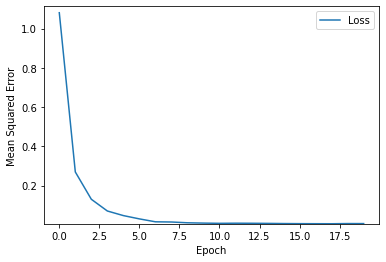

In [28]:
plot_the_loss_curve(epochs, mse)

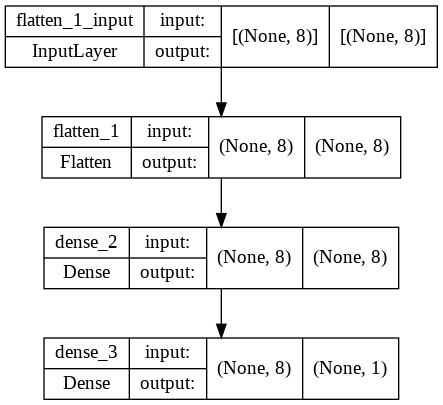

In [19]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

In [20]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=5)

Evaluate on test data
13/13 [==============================] - 0s 3ms/step - loss: 0.0085 - mean_squared_error: 0.0085


In [21]:
print("Generate predictions for 3 samples\n")
test = x_test[:3]
print(test)
predictions = model.predict(test)
print("predictions:\n", predictions*labels_max)

Generate predictions for 3 samples

     HostnameLookups  KeepAlive  EnableSendfile  FollowSymLinks  AccessLog  \
182              1.0        1.0             0.0             0.0        1.0   
183              1.0        0.0             0.0             1.0        1.0   
160              0.0        0.0             0.0             0.0        1.0   

     ExtendedStatus  InMemory  Handle  
182             0.0       1.0     0.0  
183             0.0       1.0     0.0  
160             1.0       1.0     0.0  
predictions:
 [[1829.4746]
 [1036.1244]
 [1361.4297]]


In [22]:
np.concatenate((test, predictions*labels_max), axis=1)


array([[1.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.82947461e+03],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.03612439e+03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.36142969e+03]])

In [23]:
print(predictions*labels_max)

[[1829.4746]
 [1036.1244]
 [1361.4297]]
